# Backdoor Attacks

In this tutorial you will learn how to perform several kinds of backdoor attacks. In the case of a backdoor attack, the adversary has access to (only a small subset of) the training data. By altering a few data samples, the adversary inserts a secret functionality into the trained model. Such secret functionality in a classifier is a targeted misclassification. The secret functionality, or backdoor, is activated when the model's input contains an attacker-chosen property (trigger). 

You will learn how to apply the [BadNets](https://arxiv.org/pdf/1708.06733.pdf) backdoor attack and the [Blended](https://arxiv.org/pdf/1712.05526.pdf) backdoor attack. With the BadNets  attack, you will insert a small square patch to the input images, while with the Blended attack you will blend the input image with another image. Furthermore, you will learn to apply two different modes of backdoor attacks, i.e. the source-agnostic and source-specific attacks. 

You will only apply a dirty label static backdoor attack. Dirty label because you will add the trigger to multiple classes instead of only the target class images. Also, with dirty label you will change the labels of specific input images, more on this later in this tutorial. You will perfrom static backdoor attacks, because you will apply the trigger as a static property of the input images and this trigger will not change over time.

Aside from applying the attacks, you will also learn about metrics used in this field to evaluate the attack. These metrics are the attack success rate (ASR) and the clean accuracy drop. 

Just like in the other tutorials, you will be using the MNIST dataset and a simple CNN.

## Imports

In [1]:
# for plotting and computing
import copy
import matplotlib.pyplot as plt
import numpy as np
import random

# for load bar
from tqdm import tqdm

# for image loading
from PIL import Image, ImageOps

# PyTorch packages
import torch
from torch import optim
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

## Device

We also set the device variable so that we can easily switch from using cpu to gpu (if available).

In [2]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


## Random Seed

Execute the code snippet below to set the random seed. This will ensure that you can reproduce results over multiple tries. So anyone who re-runs your code will get the exact same outputs.

For example: we will set shuffle to True and so the training loader will randomly shuffle the data over multiple runs. If you make changes to your code because training is not going well, then setting the random seed ensures that you can perform the training with the same samples as in previous tries. 

In [3]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
seed = 3131       
setup_seed(seed)

## Data

We already introduced the MNIST dataset in a previous tutorial where we trained and tested a MLP and CNN on it. It is an illustrative dataset that is also not to big and so training a new model does not take too much time. We make use of PyTorch's `DataLoader` class to create objects that we can use to sample training and test data using batches of size 128.

In [4]:
n_classes   = 10
img_size    = 28
channel     = 1
num_workers = 0
batch_size  = 128

def _init_fn(worker_id):
    np.random.seed(int(seed))

train_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=True)
train_loader = torch.utils.data.DataLoader(train_set,  batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

test_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=False)
test_loader = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

## Visualize Data

Below you find some methods to help you visualize the data.

In [5]:
def visualize_batch(images,labels):
    # making sure we can view the images
    images = images.detach().numpy()
    images = images*255
    images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]
    
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
    plt.show()

In [6]:
def visualize_image(image,label):
    image = image.detach().numpy()
    image = np.squeeze(image)
    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label is {str(label.item())}")

    # annotate each pixel in the image with its value
    width, height = image.shape
    thresh = image.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(image[x][y],2) if image[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if image[x][y]<thresh else 'black')
    plt.show()

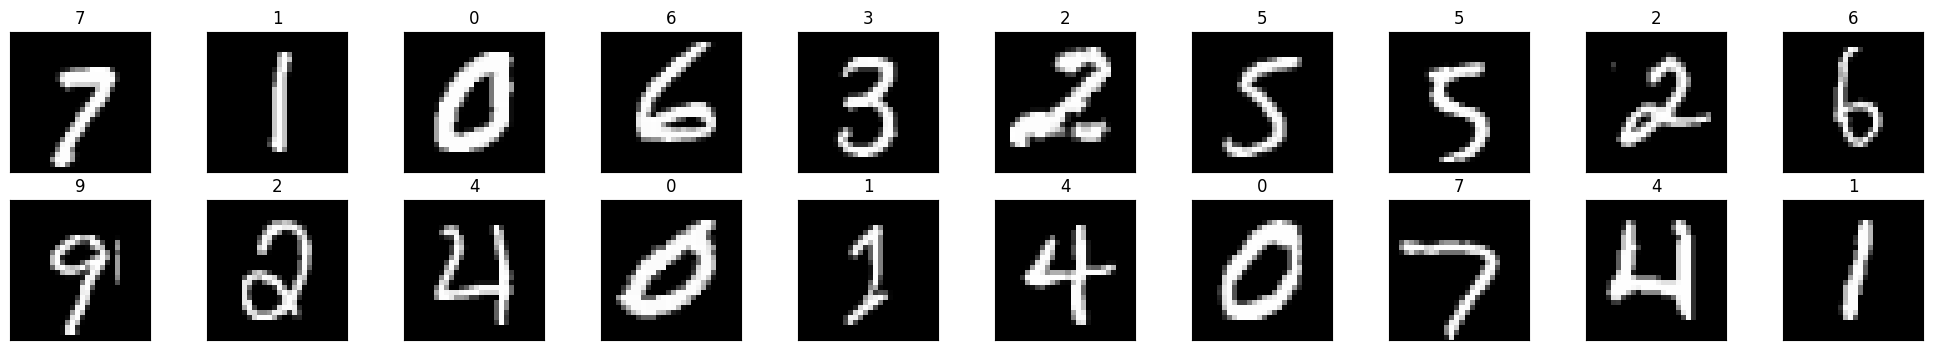

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

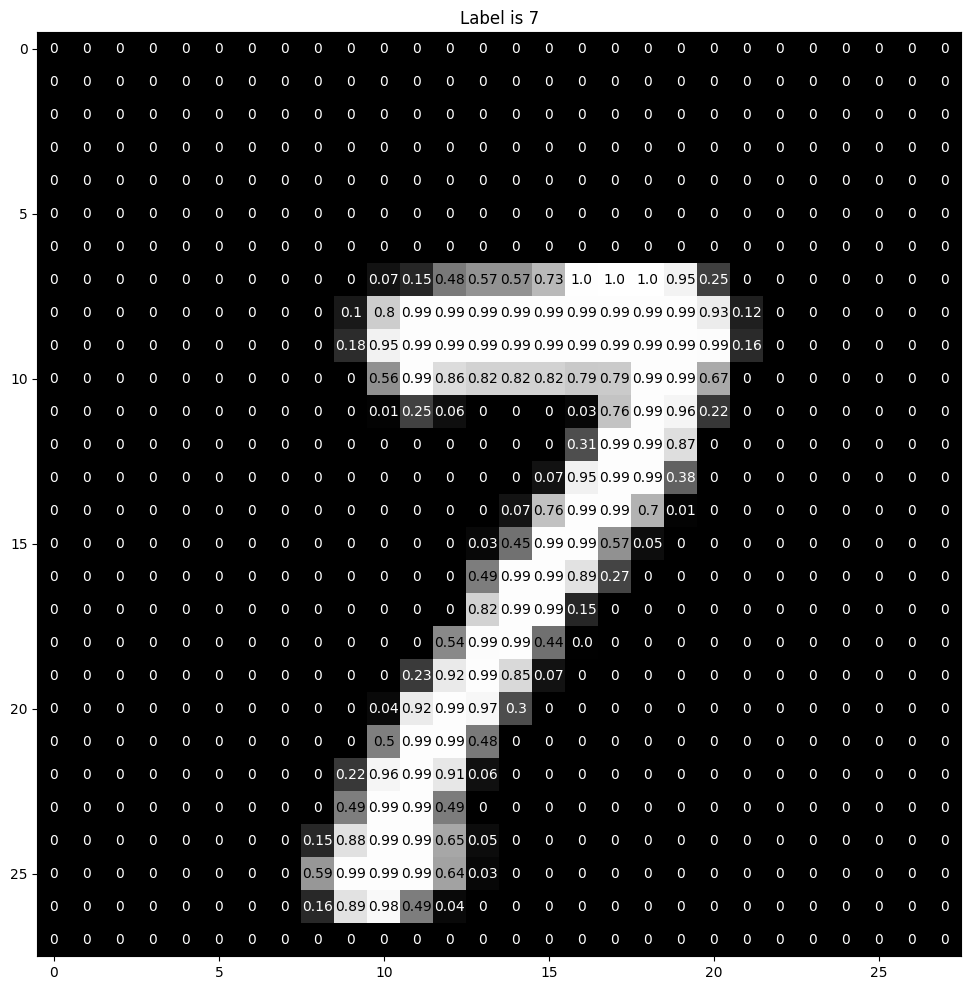

In [8]:
image, label = images[0], labels[0]
visualize_image(image,label)

## Neural Network

Below you find a simple CNN network, which you can train on the MNIST dataset.

In [24]:
class Model(Module):
    
    def __init__(self):
        super(Model, self).__init__()

        # padding added to match input size of MNIST
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) 
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Adjusting the size of the first fully connected layer to match the output from the conv layers
        # 5x5 is the spatial size of the image after conv and pooling layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # 10 output classes for MNIST
        self.fc3 = nn.Linear(84, 10) 

    def forward(self, x):       
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # No ReLU after this line, output logits directly
        x = self.fc3(x)
        return x

## Training

Below you find the same training methods as we shared in previous tutorials. You can use these to train your model.

In [25]:
# Method to compute accuracy
def accuracy(predictions,labels):
    _, preds = torch.max(predictions, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

# Method to log training / running loss and accuracy
def log_training(batch_idx, running_loss, running_acc):
    print(f"Batch: {batch_idx}, Running Loss: {running_loss / (batch_idx + 1):.2f}, Running Accuracy: {running_acc:.2f}")

def training_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate loss
    if labels.ndim != 1:
        labels = torch.squeeze(labels)
    loss = criterion(predictions, labels)
    # Calculate accuracy
    acc = accuracy(predictions, labels)
    return loss, acc

# Method to log epoch loss and accuracy
def epoch_end(result):
    print(f"val_loss: {result['val_loss']:.2f}, val_acc: {result['val_acc']:.2f}\n")

def train(model, model_name, criterion, optimizer, train_loader, num_epochs=10, scheduler=None):
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        running_loss = 0
        # Training Phase
        for batch_idx, batch in enumerate(train_loader):
            # Calculate Loss
            loss, running_acc = training_step(model, batch, criterion)
            # Compute Gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset Gradients
            optimizer.zero_grad()

            # running loss and accuracy
            running_loss += loss.item()
            if batch_idx % 50 == 0 and batch_idx != 0:
                log_training(batch_idx, running_loss, running_acc)

        # Scheduling learning rate by stepLR
        if scheduler:
            scheduler.step()


    # Save checkpoint file
    torch.save(model.state_dict(), f"{model_name}.pth")

## Testing

Below you find a simple test method which you can use to test the performance (accuracy and loss) of your model.

In [26]:
def test(model, criterion, DataLoader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    examples = []
    test_loss = []
    test_acc = []
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (inputs, targets) in enumerate(tqdm(DataLoader)):
            # Prepare batch data
            inputs, targets = inputs.to(device), targets.to(device)
            # Generate predictions
            outputs = model(inputs).detach()
            # Calculate loss
            batch_test_loss = criterion(outputs,targets)
            #Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            batch_test_acc = torch.tensor(torch.sum(predicted == targets).item() / len(predicted))
            
            # Store batch results
            test_loss.append(batch_test_loss)
            test_acc.append(batch_test_acc)
            # Store Examples
            ex = inputs[0].squeeze().detach().cpu().numpy()
            examples.append((targets[0],predicted[0],ex))

    # Display Results
    print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
    print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))
    return round(torch.stack(test_acc).mean().item(),4), examples

## Train Clean Model

First we will train a clean model on the MNIST dataset. You can use this model later to compute the clean accuracy drop. 

### Hyperparameters

In [27]:
clean_model = Model().to(device)
learning_rate = 0.001
optimizer = optim.Adam(clean_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [49]:
train(clean_model,"clean_model",criterion,optimizer,train_loader,num_epochs=5)

Epoch:  1
Batch: 50, Running Loss: 0.05, Running Accuracy: 0.97
Batch: 100, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 150, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 200, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 250, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 300, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 350, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 400, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 450, Running Loss: 0.05, Running Accuracy: 0.98
Epoch:  2
Batch: 50, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 100, Running Loss: 0.05, Running Accuracy: 1.00
Batch: 150, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 200, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 250, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 300, Running Loss: 0.05, Running Accuracy: 0.99
Batch: 350, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 400, Running Loss: 0.05, Running Accuracy: 0.98
Batch: 450, Running Loss: 0.05, Running Accurac

In [29]:
acc, examples = test(clean_model,criterion,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 45.96it/s]

Test Loss:  0.05
Test Accuracy:  98.53


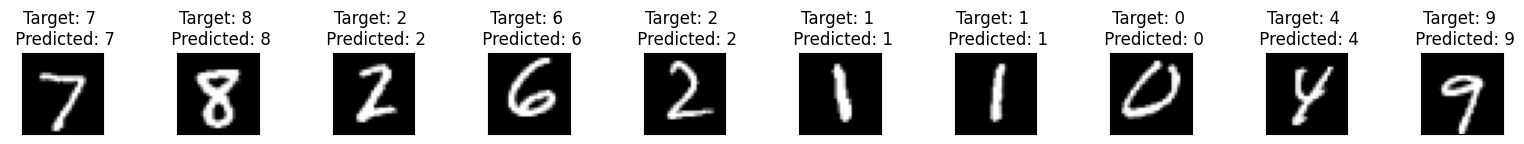

In [30]:
plt.figure(figsize=(100,100))
cnt=0
for i in range(len(examples[:10])):
    cnt += 1
    plt.subplot(len(examples),50,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    tar,adv,ex = examples[i]
    #ex = np.transpose(ex, (1, 2, 0))
    plt.title("Target: {} \n Predicted: {}".format(tar,adv))
    plt.imshow(ex, cmap="gray")

# Backdoor Attack

After training and testing your clean model, you will now start with the first backdoor attack by applying square triggers to the training set and training a new backdoored model.

## Backdoor Attack (Square Trigger)

### Create Square Trigger
You will need to finish the code below. In the code snippet below you will find the class ```GenerateSQRTrigger```, which is an object that can be used to create a square trigger inside an image. This trigger type is one of the first in the literature ([BadNets paper](https://arxiv.org/abs/1708.06733)). 

It now takes 1 parameter which is ```size```.

- ```size``` is a tuple indicating the size of the square trigger and this should not exceed the dimensions of the images in the dataset and it should always be a tuple of identical numbers.

The class also contains the following methods:

- ```_gen_pos_squre()``` should include code that creates the x and y coordinates inside the image where the square should be created (be aware that you do not exceed the dimensions of the image). 

- ```create_trigger_square()``` should include code that creates a object with the same dimensions as the images in the dataset and then places the square inside this object. 

- ```apply_trigger()``` should be used to apply the created square trigger on the actual images of the dataset. This is also used inside the ```poison(img,trigger_obj)``` method.

In [31]:
def poison(img, trigger_obj):
    """Poison the training samples by stamping the trigger."""
    poisoned_image = trigger_obj.apply_trigger(img)
    return poisoned_image

In [32]:
class GenerateSQRTrigger:
    """
    A class that creates a random square pattern that is used as a trigger for an
    image dataset.
    """

    def __init__(self, size):

        self.size = size
        self.dims = (28, 28, 1)
        
        if self.size[0] != self.size[1]:
            raise Exception("The size of the trigger must be square.")

        if self.size[0] > self.dims[0] or self.size[1] > self.dims[1]:
            raise Exception("The size of the trigger is too large for the dataset items.")

        self.pos_coords = self._gen_pos_square()
        self.crafted_trigger = self.create_trigger_square()

    def _gen_pos_square(self):
        '''
        ADD CODE HERE
        
        This method should return the x and y coordinates where the square trigger should be placed
        '''
        # We'll be placing the bottom right corner of the trigger one pixel to the left and one pixel up of the bottom right corer of the image
        
        pixel_position = self.dims[0] - self.size[0] - 1
        
        return (pixel_position, pixel_position)

    def create_trigger_square(self):
        triggered_image = np.zeros(self.dims, dtype=np.float32)
        base_x, base_y = self.pos_coords
        '''
        ADD CODE HERE
        
        Here you should use the triggered_image and x and y coordinates to create a square on that place.
        '''
        for x in range(self.size[0]):
            for y in range(self.size[1]):
                triggered_image[base_x + x][base_y + y] = 1.0
        
        return torch.squeeze(torch.tensor(triggered_image))
    
    def apply_trigger(self, img):
        """applies the trigger on the image."""

        img = torch.squeeze(img)
        
        base_x, base_y = self.pos_coords
        for x in range(self.size[0]):
            for y in range(self.size[1]):                               
                img[base_x + x][base_y + y] = self.crafted_trigger[base_x + x][base_y + y]
                
        return torch.unsqueeze(img, 0)

### Source-agnostic vs source-specific

In **source-agnostic** attacks the trigger is effective in any image, regardless its original class.
In **source-specific** attacks the trigger is effective only for a specific original class. If the trigger is applied in any other input the model should classify the poisoned input correctly.

Now you should use the code above to poison the training data. You will need to decide on the following settings:
- Source specific: Do you want the attack to be source specific, if so then provide a variable with the source label.
- Backdoor / target label: If an image includes a trigger, what should the target label be?
- Epsilon: specify what percentage of the training set you want to poison.

Do the following when poisoning the training dataset in case of a **source agnostic** attack:
- If a training set example is part of the subset you want to poison, then poison the image and provide the backdoor label as its new label.
- If a training set example is not part of the subset you want to poison, then use the original image and label.

Do the following when poisoning the training dataset in case of a **source specific** attack:

- If a training set example is part of the subset you want to poison and its original label is equal to the source label, poison the image and provide the backdoor label as its new label.
- If a training set example is part of the subset you want to poison and its original label is not equal to the source label, poison the image and provide the original label.
- If a training set example is not part of the subset you want to poison, then use the original image and label.

**Tip**: In one of the previous tutorials we explained how you can make a custom dataset using PyTorch Dataset class. Take a look at that tutorial and consider using this information to create a specific backdoored dataset. This way you can create a dataset that follows the rules explained above, which you can then easily pass on to the DataLoader class.

In [91]:
'''
YOUR CODE HERE
'''
# Reuse? Reduce? Ecycy?
class SourceSpecificBadNetBackdoorMNIST(Dataset):
    def __init__(self, source_label: int, target_label: int, epsilon: float, attacker: GenerateSQRTrigger, train: bool) -> None:
        super().__init__()
        
        self.clean_mnist_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=train)
        self.clean_mnist_loader = DataLoader(self.clean_mnist_set, batch_size=1, shuffle=True)
        self.backdoored_mnist_set = []
        
        backdoored_sample_count = round(len(self.clean_mnist_set) * epsilon, 0)
                
        for index, (image, label) in enumerate(self.clean_mnist_loader):            
            label = label.item()
            
            if index < backdoored_sample_count:
                backdoored_image = attacker.apply_trigger(image)
            
                if label == source_label:
                    self.backdoored_mnist_set.append((backdoored_image, target_label))
                else:
                    self.backdoored_mnist_set.append((backdoored_image, label))  
            else:
                image = torch.squeeze(image, 0)
                self.backdoored_mnist_set.append((image, label))
                                        
    def __len__(self) -> int:
        return len(self.backdoored_mnist_set)
    
    def __getitem__(self, index):
        return self.backdoored_mnist_set[index]

target_label = 9
source_label = 6
size = (5, 5)
trigger_obj = GenerateSQRTrigger(size)

training_epsilon = 0.1
bkdr_training_set = SourceSpecificBadNetBackdoorMNIST(source_label, target_label, training_epsilon, trigger_obj, True)
bkdr_train_loader = DataLoader(bkdr_training_set, batch_size=128, shuffle=True)

test_epsilon = 0.1
bkdr_test_set = SourceSpecificBadNetBackdoorMNIST(source_label, target_label, training_epsilon, trigger_obj, False)
bkdr_test_loader = DataLoader(bkdr_test_set, batch_size=128, shuffle=True)

In [92]:
bkdr_model = Model().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(bkdr_model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
# %%
train(bkdr_model, "bkdr_model", criterion, optimizer, bkdr_train_loader,num_epochs=5)

Epoch:  1
Batch: 50, Running Loss: 1.75, Running Accuracy: 0.70
Batch: 100, Running Loss: 1.22, Running Accuracy: 0.85
Batch: 150, Running Loss: 0.98, Running Accuracy: 0.91
Batch: 200, Running Loss: 0.84, Running Accuracy: 0.83
Batch: 250, Running Loss: 0.75, Running Accuracy: 0.91
Batch: 300, Running Loss: 0.68, Running Accuracy: 0.93
Batch: 350, Running Loss: 0.62, Running Accuracy: 0.94
Batch: 400, Running Loss: 0.58, Running Accuracy: 0.95
Batch: 450, Running Loss: 0.54, Running Accuracy: 0.92
Epoch:  2
Batch: 50, Running Loss: 0.20, Running Accuracy: 0.98
Batch: 100, Running Loss: 0.18, Running Accuracy: 0.95
Batch: 150, Running Loss: 0.17, Running Accuracy: 0.95
Batch: 200, Running Loss: 0.17, Running Accuracy: 0.91
Batch: 250, Running Loss: 0.17, Running Accuracy: 0.98
Batch: 300, Running Loss: 0.16, Running Accuracy: 0.96
Batch: 350, Running Loss: 0.15, Running Accuracy: 0.99
Batch: 400, Running Loss: 0.15, Running Accuracy: 0.94
Batch: 450, Running Loss: 0.15, Running Accurac

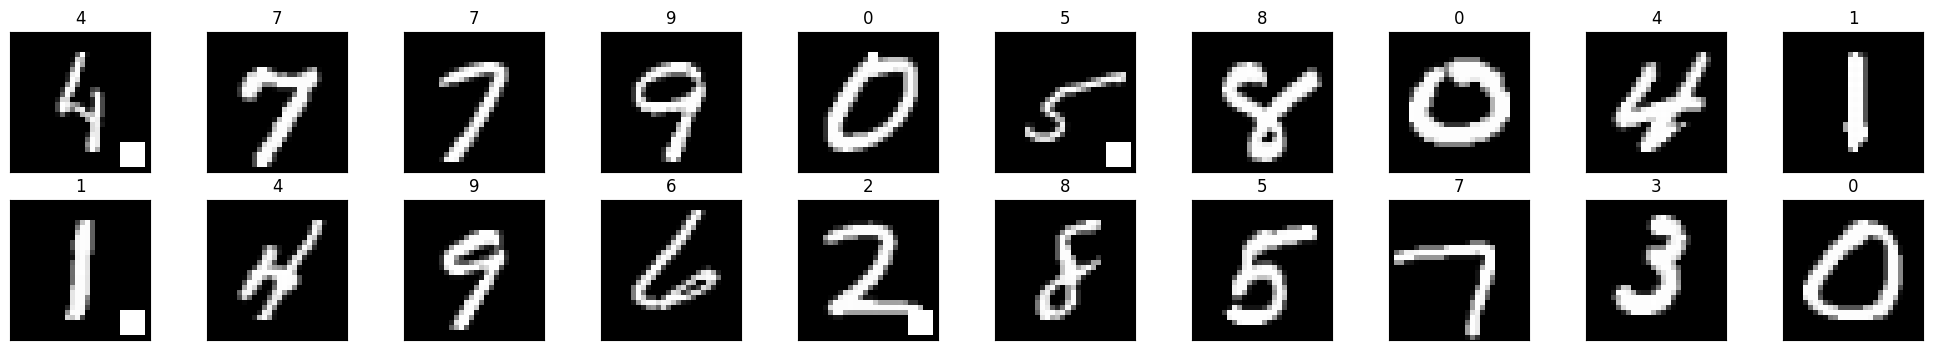

In [93]:
# obtain one batch of training images
dataiter = iter(bkdr_train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

### Evaluation

#### Attack Succes Rate

Use the method ```calculate_ASR()``` to compute the attack success rate of your backdoored model. 

You will need a trained backdoored model. Then use the method below while providing a **poisoned test set in the form of a DataLoader**. Also provide the same trigger object, backdoor label and original label used during poisoning of training set. Do not specify an epsilon value for the test set as you simply want to poison all samples to calculate ASR.

The method below assumes a test dataloader from a test dataset of (poisoned_image,original_label) pairs. The reason it assumes original labels instead of target/backdoor labels is to compute the ASR in the source specific case. Here we need to know if the original label was the source label and if that image is then missclassified with the target/backdoor label. This is only assumed for the test set! The train dataset should be of (poisoned_image,target_label) pairs.

In case of a source specific attack you compute the ASR only for images with the specific source label. However, you also poison other labeled images. With ```verbose``` set to True the method will print in how many cases of these other labeled images the prediction was equal to the target label instead of the original label. 

In [94]:
def find_source_indices(y_test,source_label):
    indices = (y_test == source_label).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def find_non_source_indices(y_test,source_label,target_label):
    # get indices of samples which do not have source or target label
    indices = torch.logical_and((y_test != source_label),(y_test != target_label)).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def count_non_source_misclassifications(original_labels,predicted,source_label,target_label):
    sub_non_source_total = 0
    sub_misclassifications = 0

    # find all the images with a different label than the source or target label
    indices = find_non_source_indices(original_labels,source_label,target_label)
    sub_non_source_total += indices.shape[0]

    # for all non-source and non-target label images check if the prediction is equal to the target label
    for index in indices:
        if predicted[index].detach().cpu().numpy() == target_label:
            sub_misclassifications += 1
    return sub_misclassifications, sub_non_source_total

def count_source_specific_classifications(original_labels,predicted,source_label,target_label):
    sub_total = 0
    sub_correct = 0
    
    # find all the images with the source label
    indices = find_source_indices(original_labels,source_label)
    sub_total += indices.shape[0]
    
    # for all source label images check if the prediction is equal to the target label
    for i in indices:
        if predicted[i].detach().cpu().numpy() == target_label:
            sub_correct +=1
    return sub_correct, sub_total

def calculate_ASR(model,dataloader,target_label,source_label=None,verbose=False):
    correct = 0
    total = 0

    non_source_total = 0
    misclassifications = 0

    with torch.no_grad():
        model.eval()

        for inputs, original_labels in tqdm(dataloader):
            # Use poisoned test image to get predictions of backdoored model
            inputs = inputs.to(device)
            outputs = model(inputs).detach()
            _, predicted = torch.max(outputs, dim=1)
            
            # If source specific attack
            if source_label is not None:
                sub_correct, sub_total = count_source_specific_classifications(original_labels,predicted,source_label,target_label)
                correct += sub_correct
                total += sub_total
                if verbose:
                    sub_misclassifications, sub_non_source_total = count_non_source_misclassifications(original_labels,predicted,source_label,target_label)
                    misclassifications += sub_misclassifications
                    non_source_total += sub_non_source_total
            # if source agnostic attack
            else:
                # for all test samples check if the predicted label is equal to the target label
                for i in range(len(inputs)):
                    if original_labels[i] != target_label:
                        total += 1
                        if predicted[i].detach().cpu().item() == target_label:
                            correct += 1

    attack_acc = (correct * 100.0) / total
    print(f"Attack accuracy: {round(attack_acc,2)}")
    
    if source_label and verbose:
        print(misclassifications)
        print(non_source_total)
        misclassification_rate = (misclassifications * 100.0) / non_source_total
        print(f"False Positive rate: {round(misclassification_rate,2)}")
        
    return attack_acc

In [95]:
attack_acc = calculate_ASR(bkdr_model,bkdr_test_loader,target_label=target_label,source_label=source_label,verbose=True)

100%|██████████| 79/79 [00:00<00:00, 87.39it/s]

Attack accuracy: 0.12
14
8033
False Positive rate: 0.17


#### Clean Accuracy Drop

In order to compute the clean accuracy drop you will need to first train a model on the clean training set and use the ```test()``` method provided earlier on in this notebook to compute the clean accuracy. Then train a model using the backdoored/poisoned training set. Again use the same ```test()```method to compute the accuracy of this backdoored model on the clean test set. Compare the accuracies to compute the accuracy drop.

In [97]:
'''
YOUR CODE HERE
'''
def clean_accuracy_drop(clean_test_loader, clean_model, backdoored_model):
    loss_fn = torch.nn.CrossEntropyLoss()
    
    clean_model_accuracy = test(clean_model, loss_fn, clean_test_loader)[0]
    backdoored_model_accuracy = test(backdoored_model, loss_fn, clean_test_loader)[0]
    
    return clean_model_accuracy - backdoored_model_accuracy

clean_accuracy_drop(test_loader, clean_model, bkdr_model)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:03<00:00, 25.87it/s]


Test Loss:  0.05
Test Accuracy:  98.53


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:03<00:00, 25.92it/s]

Test Loss:  0.05
Test Accuracy:  98.51


0.00019999999999997797

## Backdoor Attack (Blend)

This attack was introduced in [Targeted backdoor attacks through data poisoning](https://arxiv.org/abs/1712.05526) and it was one of the first backdoor generation techniques. As a trigger a base image is "blended" with the original inputs. In this paper the authors used 2 images for the blending. One was an image from "Hello Kitty" and another was an image with random pixel values. The constructor of the following class needs two arguments, the dataset and the trigger type. 

The ```trigger_blended``` function loads the correct image and saves it in ```self.crafted_trigger```. 

The method ```apply_trigger``` blends a given input with the trigger, and returns the result (poisoned image). The blending happens by simply adding the loaded trigger (which is saved in ```self.crafted_trigger```) to the input image and then divides the result by 2. Make sure you return an image of the correct type (```np.float32```).

In [125]:
class GenerateBlendedTrigger:
    """
    A class that uses images of the same dimensions as the dataset as triggers
    that will be blended with the clean images.

    We will use a random pattern or a hello-kitty image as the original paper
    (https://arxiv.org/pdf/1712.05526.pdf).
    """

    def __init__(self, dataset, trigger):        
        datasets_dimensions = {"mnist": (28, 28, 1),
                               "cifar10": (32, 32, 3),
                               "fmnist": (28, 28, 1)}

        if trigger not in ["random", "hello-kitty"]:
            raise Exception(f"Pick 'random' or 'hello-kitty' trigger")

        if dataset not in datasets_dimensions:
            raise Exception(f"Dataset is not supported")
        
        # Use a hardcoded seed for reproducibility
        dims = datasets_dimensions[dataset]

        self.dims = dims
        self.dataset = dataset

        # Generate the correct trigger
        self.crafted_trigger = self.trigger_blended(trigger)

    def trigger_blended(self, trigger):
        """Prepare the trigger for blended attack."""
        if trigger == "hello-kitty":
            '''
            ADD CODE HERE
        
            You should:
            1) load the hello kitty image
            2) make sure it has the correct size
            3) make sure it has the correct color setting
            4) normalize to make it have the corect range
            5) return the array
            '''
            hello_kitty_path = "./hello_kitty.jpg"
            hello_kitty_image = Image.open(hello_kitty_path)
            hello_kitty_image = hello_kitty_image.resize((self.dims[0], self.dims[1]))
            
            if self.dataset != "cifar10":
                hello_kitty_image = ImageOps.grayscale(hello_kitty_image)
                        
            trigger_array = np.array(hello_kitty_image)
            trigger_array = trigger_array / 255
        else:
            # Create a np.array with the correct dimensions
            # fill the pixels with random values
            trigger_array = (random((self.dims)))

        return trigger_array

    def apply_trigger(self, img):
        '''
        ADD CODE HERE
    
        You should:
        1) add the trigger to the input image
        2) divide the total by 2
        3) cast the resulting image to the correct type
        '''
        backdoored_image = img + self.crafted_trigger
        backdoored_image = backdoored_image / 2
        backdoored_image = backdoored_image.to(torch.float32)
        
        return backdoored_image

### Source-agnostic vs source-specific

In **source-agnostic** attacks the trigger is effective in any image, regardless its original class.
In **source-specific** attacks the trigger is effective only for a specific original class. If the trigger is applied in any other input the model should classify the poisoned input correctly.

Now you should use the code above to poison the training data. Again, decide on the following settings:
- source specific: Do you want the attack to be source specific, if so then provide a variable with the source label.
- backdoor / target label: If an image includes a trigger, what should the target label be?
- epsilon: specify what percentage of the training set you want to poison.

Do the following when poisoning the training dataset in case of a **source agnostic** attack:
- if a training set example is part of the subset you want to poison, then poison the image and provide the backdoor label as its new label.
- if a training set example is not part of the subset you want to poison, then use the original image and label.

Do the following when poisoning the training dataset in case of a **source specific** attack:

- if a trainig set example is part of the subset you want to poison and its original label is equal to the source label, poison the image and provide the backdoor label as its new label.
- if a training set example is part of the subset you want to poison and its original label is not equal to the source label, poison the image and provide the original label.
- if a training set example is not part of the subset you want to poison, then use the original image and label.

**Different Tip**: In the last section, if you followed the previous tip, you have written a backdoor dataset class which you can use to create a backdoored dataset. Now, if you wrote this class in a clever way, this means that for this part it will be just plug & play. What we try to say is that you should write your backdoor dataset class in a more abstract/general way, such that you can simply insert a different ```trigger_obj``` and it will also work.

In [126]:
'''
YOUR CODE HERE
'''
# Reuse? Reduce? Ecycy?
class SourceSpecificBlendBackdoorMNIST(Dataset):
    def __init__(self, source_label: int, target_label: int, epsilon: float, attacker: GenerateBlendedTrigger, train: bool) -> None:
        super().__init__()
        
        self.clean_mnist_set = torchvision.datasets.MNIST(root='../week-3/data', transform=transforms.ToTensor(), download=True, train=train)
        self.clean_mnist_loader = DataLoader(self.clean_mnist_set, batch_size=1, shuffle=True)
        self.backdoored_mnist_set = []
        
        backdoored_sample_count = round(len(self.clean_mnist_set) * epsilon, 0)
                
        for index, (image, label) in enumerate(self.clean_mnist_loader):            
            label = label.item()
            image = torch.squeeze(image, 0)
            
            if index < backdoored_sample_count:
                backdoored_image = attacker.apply_trigger(image)
            
                if label == source_label:
                    self.backdoored_mnist_set.append((backdoored_image, target_label))
                else:
                    self.backdoored_mnist_set.append((backdoored_image, label))  
            else:
                self.backdoored_mnist_set.append((image, label))
                                        
    def __len__(self) -> int:
        return len(self.backdoored_mnist_set)
    
    def __getitem__(self, index):
        return self.backdoored_mnist_set[index]

target_label = 9
source_label = 6
trigger_obj = GenerateBlendedTrigger("mnist", "hello-kitty")

training_epsilon = 0.5
bkdr_training_set = SourceSpecificBlendBackdoorMNIST(source_label, target_label, training_epsilon, trigger_obj, True)
bkdr_train_loader = DataLoader(bkdr_training_set, batch_size=128, shuffle=True)

test_epsilon = None
bkdr_test_set = SourceSpecificBlendBackdoorMNIST(source_label, target_label, training_epsilon, trigger_obj, False)
bkdr_test_loader = DataLoader(bkdr_test_set, batch_size=128, shuffle=True)

In [127]:
bkdr_model = Model().to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(bkdr_model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
train(bkdr_model, 'blended_net', criterion, optimizer, bkdr_train_loader,num_epochs=5)

Epoch:  1
Batch: 50, Running Loss: 1.98, Running Accuracy: 0.60
Batch: 100, Running Loss: 1.42, Running Accuracy: 0.78
Batch: 150, Running Loss: 1.15, Running Accuracy: 0.84
Batch: 200, Running Loss: 0.98, Running Accuracy: 0.85
Batch: 250, Running Loss: 0.87, Running Accuracy: 0.94
Batch: 300, Running Loss: 0.80, Running Accuracy: 0.89
Batch: 350, Running Loss: 0.74, Running Accuracy: 0.91
Batch: 400, Running Loss: 0.69, Running Accuracy: 0.91
Batch: 450, Running Loss: 0.65, Running Accuracy: 0.92
Epoch:  2
Batch: 50, Running Loss: 0.29, Running Accuracy: 0.93
Batch: 100, Running Loss: 0.28, Running Accuracy: 0.91
Batch: 150, Running Loss: 0.27, Running Accuracy: 0.95
Batch: 200, Running Loss: 0.26, Running Accuracy: 0.94
Batch: 250, Running Loss: 0.26, Running Accuracy: 0.91
Batch: 300, Running Loss: 0.25, Running Accuracy: 0.95
Batch: 350, Running Loss: 0.24, Running Accuracy: 0.96
Batch: 400, Running Loss: 0.24, Running Accuracy: 0.95
Batch: 450, Running Loss: 0.23, Running Accurac

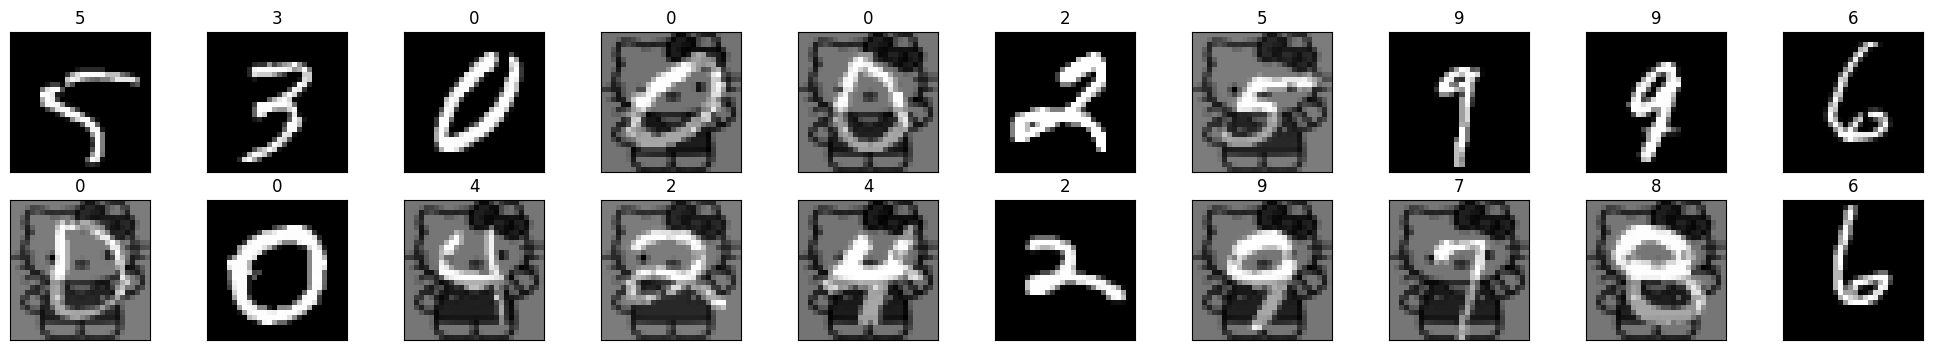

In [128]:
# obtain one batch of training images
dataiter = iter(bkdr_train_loader)
images, labels = next(dataiter)
visualize_batch(images,labels)

### Evaluate

Perform the same evaluation as in the previous section. You can re-use the same methods.

#### Attack Succes Rate

Use the method ```calculate_ASR()``` to compute the attack success rate of you backdoored model. 

First train a new model using the poisoned training set. Then use the method below while providing the a **poisoned test set in the form of a DataLoader**. Also provide the same trigger object, backdoor label and original label used during poisoning of training set.

The method below assumes a test dataloder from a test dataset of (poisoned_image,original_label) pairs. The reason it assumes original labels instead of target/backdoor labels is to compute the ASR in the source specific case. Here we need to know if the original label was the source label and if that image is then missclassified with the target/backdoor label. This is only assumed for the test set! The train dataset is of (poisoned_image,target_label) pairs.

In [129]:
def find_source_indices(y_test,source_label):
    indices = (y_test == source_label).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def find_non_source_indices(y_test,source_label,target_label):
    # get indices of samples which do not have source or target label
    indices = torch.logical_and((y_test != source_label),(y_test != target_label)).nonzero(as_tuple=False).numpy()
    indices = indices.reshape(indices.shape[0])
    return indices

def count_non_source_misclassifications(original_labels,predicted,source_label,target_label):
    sub_non_source_total = 0
    sub_misclassifications = 0

    # find all the images with a different label than the source or target label
    indices = find_non_source_indices(original_labels,source_label,target_label)
    sub_non_source_total += indices.shape[0]

    # for all non-source and non-target label images check if the prediction is equal to the target label
    for index in indices:
        if predicted[index].detach().cpu().numpy() == target_label:
            sub_misclassifications += 1
    return sub_misclassifications, sub_non_source_total

def count_source_specific_classifications(original_labels,predicted,source_label,target_label):
    sub_total = 0
    sub_correct = 0
    
    # find all the images with the source label
    indices = find_source_indices(original_labels,source_label)
    sub_total += indices.shape[0]
    
    # for all source label images check if the prediction is equal to the target label
    for i in indices:
        if predicted[i].detach().cpu().numpy() == target_label:
            sub_correct +=1
    return sub_correct, sub_total

def calculate_ASR(model,dataloader,target_label,source_label=None,verbose=False):
    correct = 0
    total = 0

    non_source_total = 0
    misclassifications = 0

    with torch.no_grad():
        model.eval()

        for inputs, original_labels in tqdm(dataloader):
            # Use poisoned test image to get predictions of backdoored model
            inputs = inputs.to(device)
            outputs = model(inputs).detach()
            _, predicted = torch.max(outputs, dim=1)
            
            # If source specific attack
            if source_label is not None:
                sub_correct, sub_total = count_source_specific_classifications(original_labels,predicted,source_label,target_label)
                correct += sub_correct
                total += sub_total
                if verbose:
                    sub_misclassifications, sub_non_source_total = count_non_source_misclassifications(original_labels,predicted,source_label,target_label)
                    misclassifications += sub_misclassifications
                    non_source_total += sub_non_source_total
            # if source agnostic attack
            else:
                # for all test samples check if the predicted label is equal to the target label
                for i in range(len(inputs)):
                    if original_labels[i] != target_label:
                        total += 1
                        if predicted[i].detach().cpu().item() == target_label:
                            correct += 1

    attack_acc = (correct * 100.0) / total
    print(f"Attack accuracy: {round(attack_acc,2)}")
    
    if source_label and verbose:
        misclassification_rate = (misclassifications * 100.0) / non_source_total
        print(f"False Positive rate: {round(misclassification_rate,2)}")
        
    return attack_acc

In [130]:
attack_acc = calculate_ASR(bkdr_model,bkdr_test_loader,target_label=target_label,source_label=source_label,verbose=True)

100%|██████████| 79/79 [00:00<00:00, 88.77it/s]

Attack accuracy: 0.0
False Positive rate: 0.44


#### Clean Accuracy Drop

In order to compute the clean accuracy drop you will need to first train a model on the clean training set and use the ```test()``` method provided earlier on in this notebook to compute the clean accuracy. Then train a model using the backdoored/poisoned training set. Again use the same ```test()```method to compute the accuracy of this backdoored model on the clean test set. Compare the accuracies to compute the accuracy drop.

In [131]:
'''
YOUR CODE HERE
'''
clean_accuracy_drop(test_loader, clean_model, bkdr_model)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.59it/s]


Test Loss:  0.05
Test Accuracy:  98.53


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:03<00:00, 20.25it/s]

Test Loss:  0.06
Test Accuracy:  98.0


0.005299999999999971